In [1]:
## Imports

## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import pickle
import sigpy as sp
import cupy as cp
import numpy as np
from numpy import fft
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates
from scipy import ndimage
import napari
import nibabel as nib

def rotate_90(img):
    return ndimage.rotate(img,-90)

## High resolution radial data

In [2]:
data_dir = '/home/lilianae/projects/data/processed/'

recon_all_channels = 'mid00118_all_channels_recon'

with open(os.path.join(data_dir, recon_all_channels), 'rb') as f:
    recon_all_channels_loaded = pickle.load(f)

print(f'recon_all_channels_loaded.shape = {recon_all_channels_loaded.shape}')

recon_all_channels_loaded.shape = (15, 58, 256, 256)


### Show individual coil recons

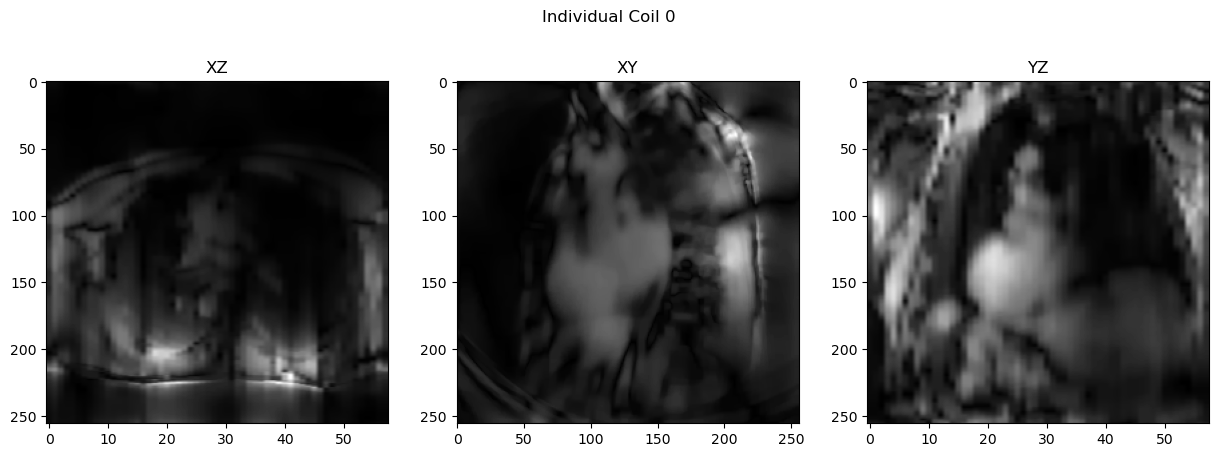

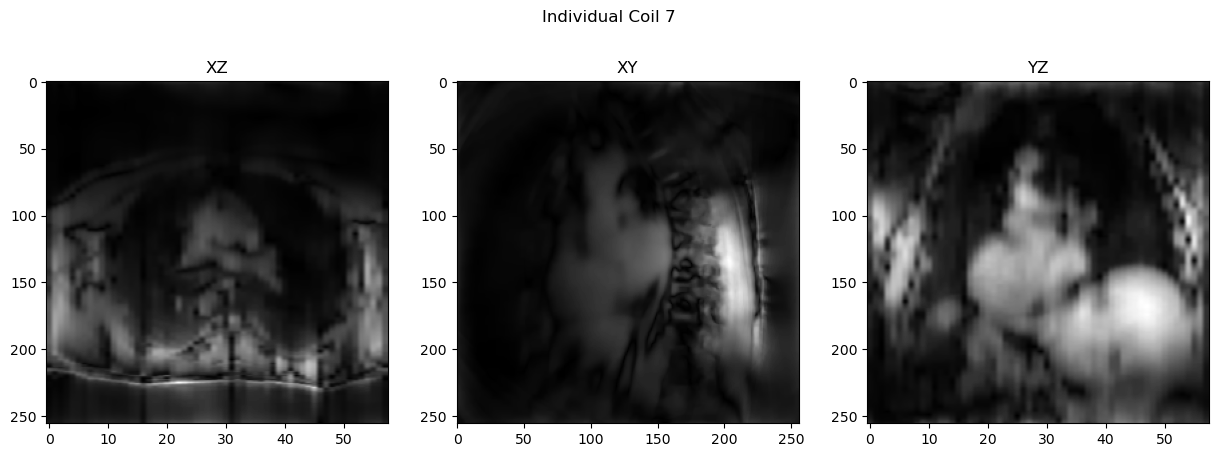

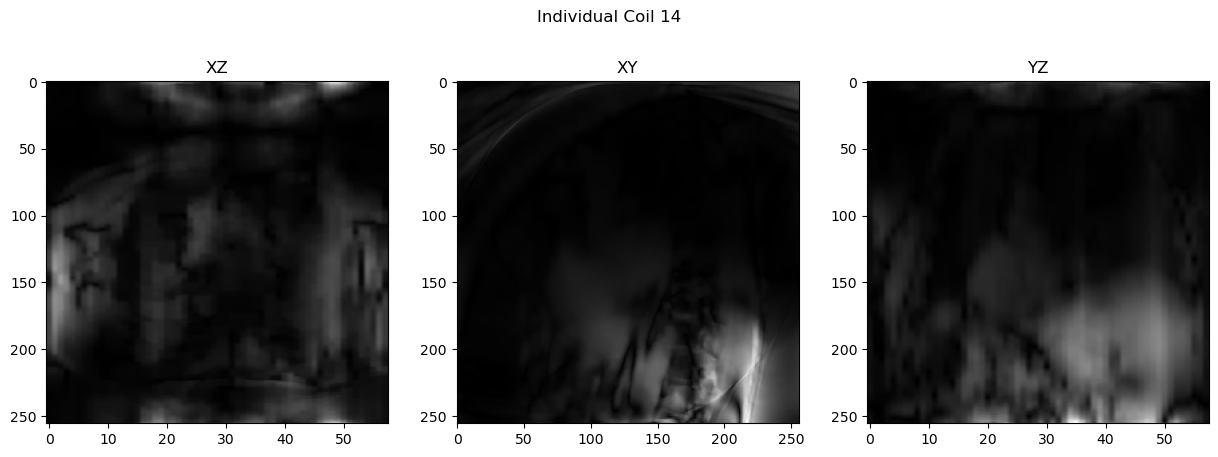

In [ ]:
def display_coil_data(img, coil_idx, z_idx=None, y_idx=None, x_idx=None):
    _, Nz, Ny, Nx = img.shape
    if z_idx is None:
        z_idx = Nz//2
    if y_idx is None:
        y_idx = Ny //2
    if x_idx is None:
        x_idx = Nx//2

    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    aspect = Nz /Nx
    axs[0].imshow(np.flipud(img[coil_idx, :, y_idx, :].T), cmap='gray', aspect=aspect)
    axs[0].set_title("XZ")
    axs[1].imshow(rotate_90(img[coil_idx, z_idx, :, :].T), cmap='gray', aspect=1.)
    axs[1].set_title("XY")
    axs[2].imshow(img[coil_idx, :, :, x_idx].T, cmap='gray', aspect=aspect)
    axs[2].set_title("YZ")

    fig.suptitle(f"Individual Coil {coil_idx}")
    plt.show()

display_coil_data(recon_all_channels_loaded, coil_idx=0, y_idx=100)
display_coil_data(recon_all_channels_loaded, coil_idx=7, y_idx=100)
display_coil_data(recon_all_channels_loaded, coil_idx=14, y_idx=100)

### Root sum-of-squares on coil images

(15, 58, 256, 256)
1.0


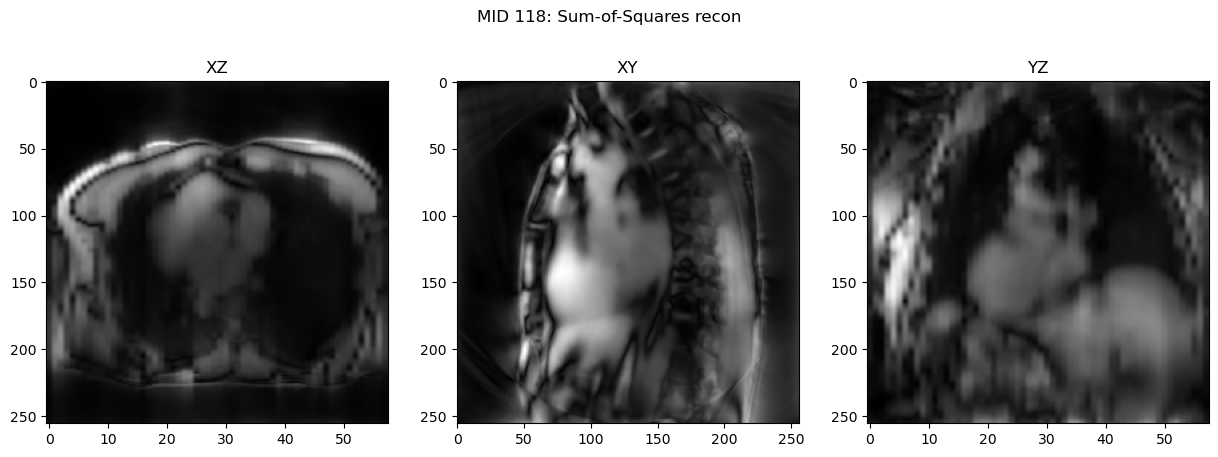

In [15]:
def calculate_sos_img(recon_all_channels, plot=True, x_idx=None, y_idx=None, z_idx=None):

    # Normalize the intensities on a coil by coil basis
    recon_all_channels_norm = recon_all_channels / np.max(np.abs(recon_all_channels))
    print(recon_all_channels_norm.shape)
    print(np.max(recon_all_channels_norm))

    # SoS
    sos_img = np.sqrt(np.sum(np.abs(recon_all_channels_norm ** 2), axis=0))

    # Dimensions
    Nz, Ny, Nx = sos_img.shape

    if plot:
        fig, axs = plt.subplots(1,3, figsize=(15, 5))
        aspect = Nz /Nx

        ## Set indices if not set
        if z_idx is None:
            z_idx = Nz//2
        if y_idx is None:
            y_idx = Ny //2
        if x_idx is None:
            x_idx = Nx//2

        axs[0].imshow(np.flipud(sos_img[ :, y_idx, :].T), cmap='gray', aspect=aspect)
        axs[0].set_title("XZ")
        axs[1].imshow(rotate_90(sos_img[z_idx, :, :].T), cmap='gray', aspect=1.)
        axs[1].set_title("XY")
        axs[2].imshow(sos_img[:, :, x_idx].T, cmap='gray', aspect=aspect)
        axs[2].set_title("YZ")

        fig.suptitle(f"MID 118: Sum-of-Squares recon")
        plt.show()

    return recon_all_channels_norm, sos_img

recon_all_channels_norm, sos_img = calculate_sos_img(recon_all_channels_loaded)

### Divide SoS recon by coil images

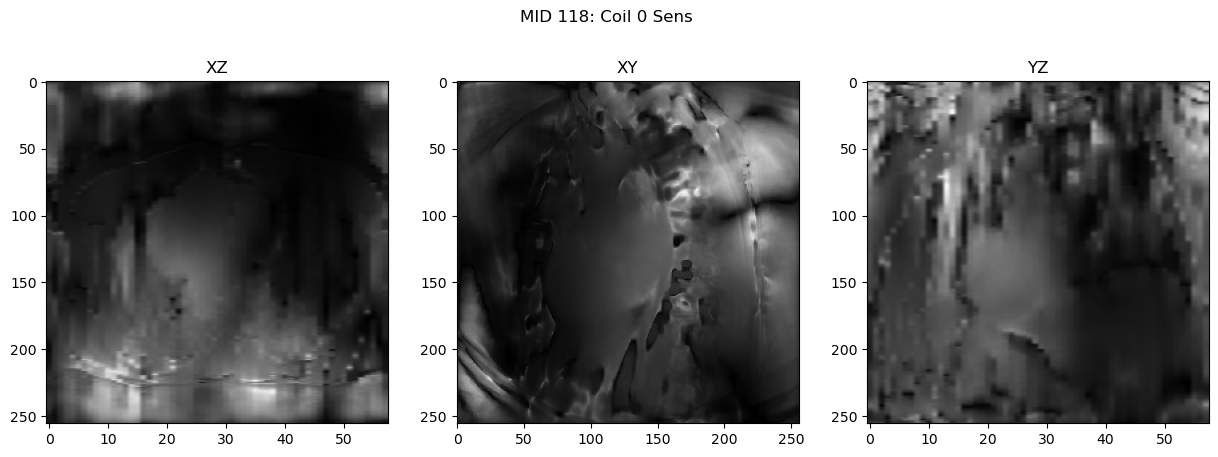

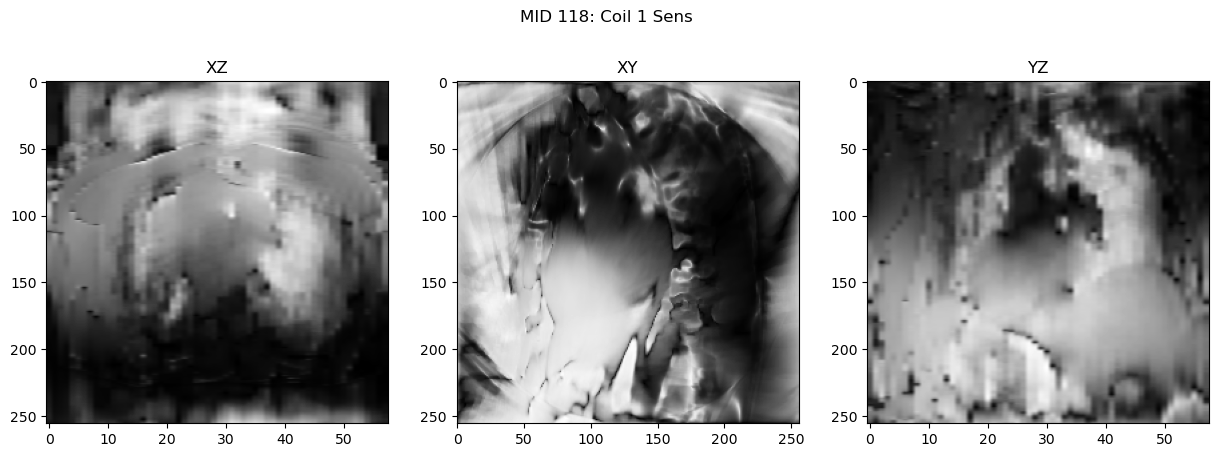

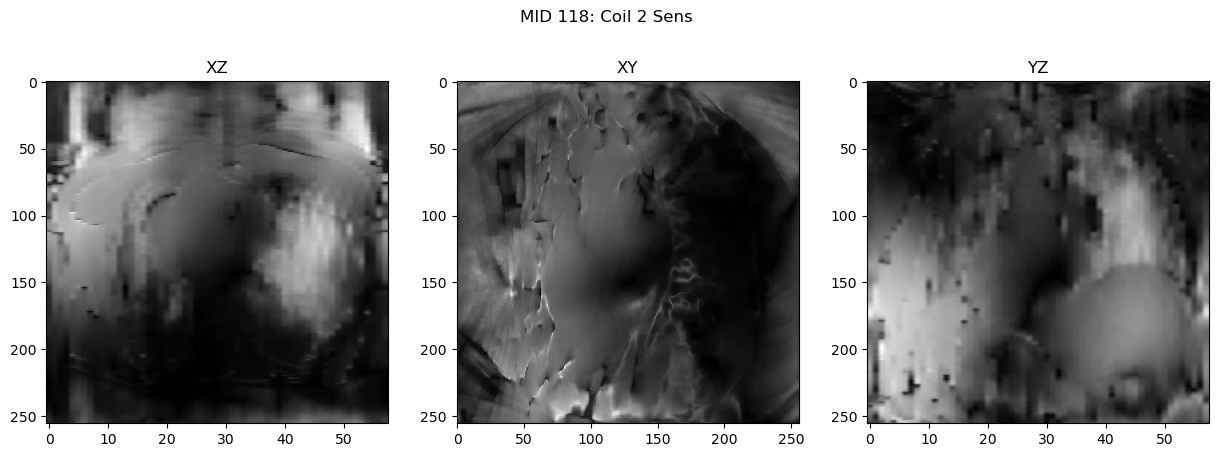

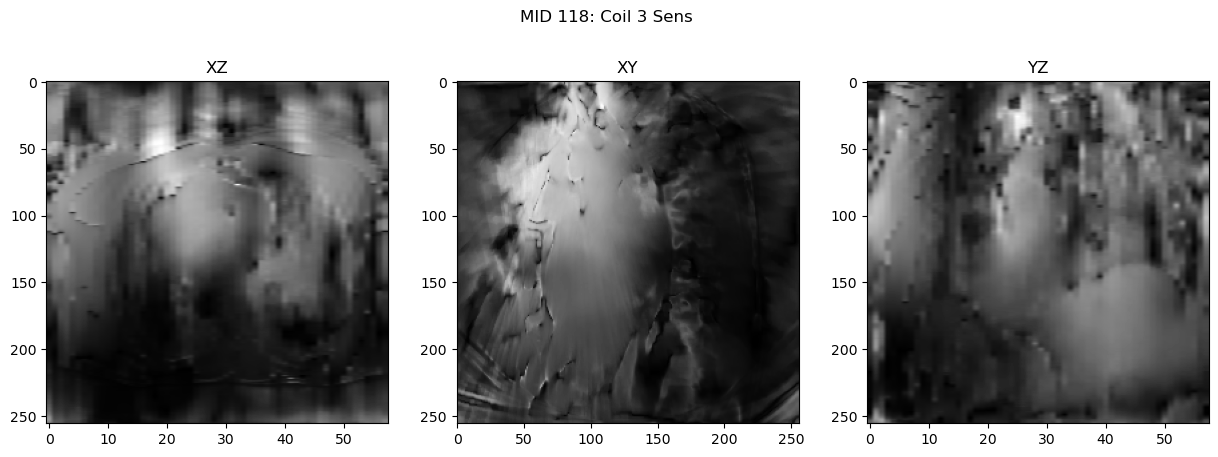

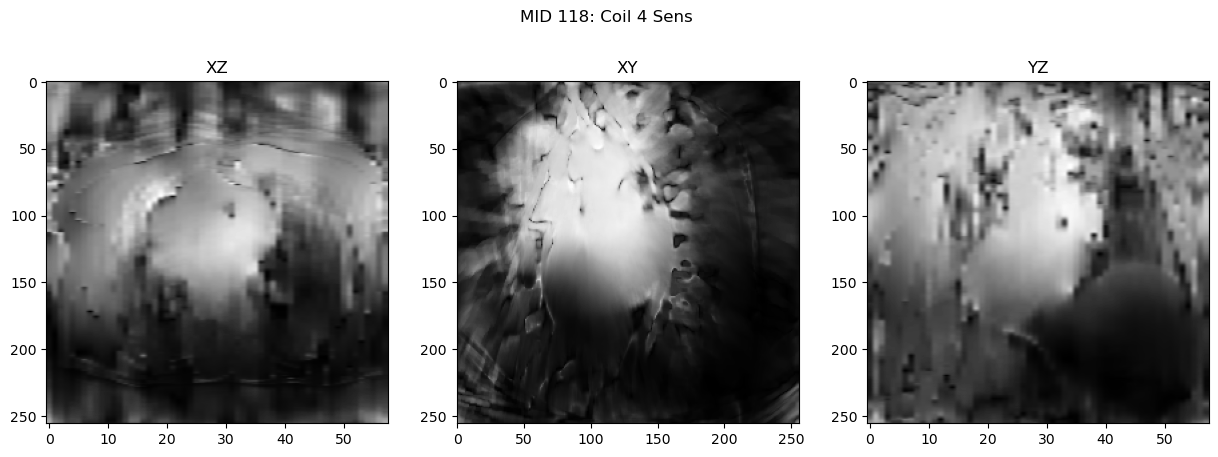

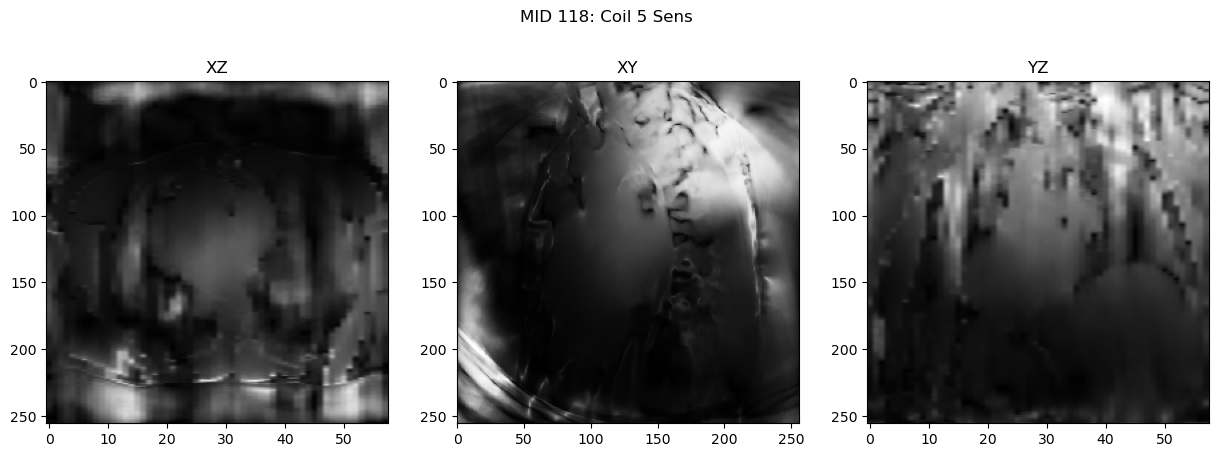

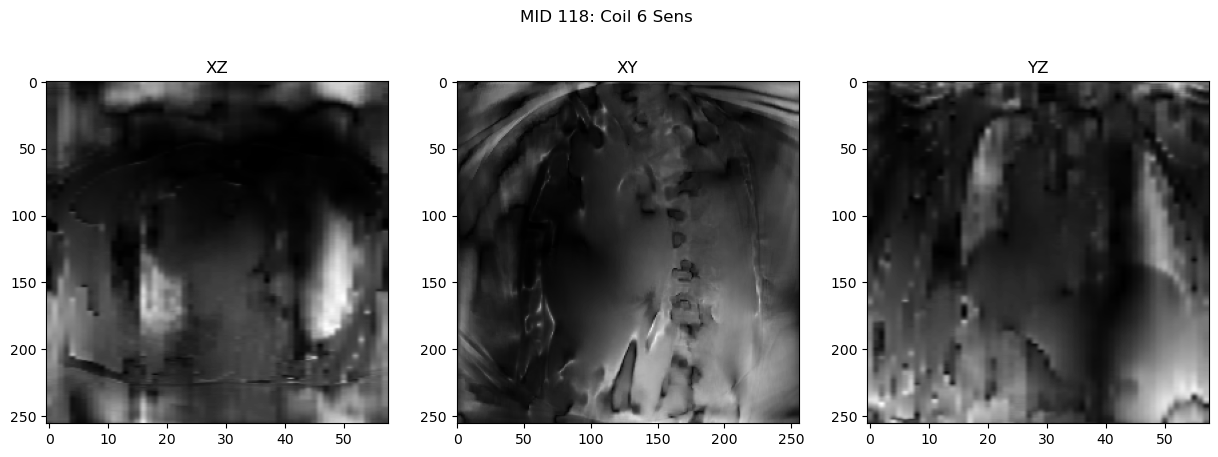

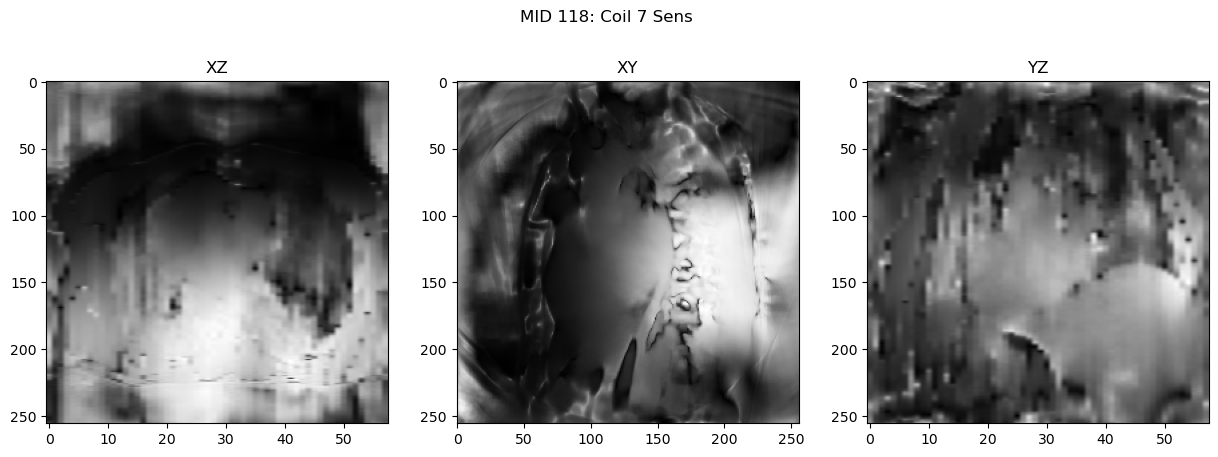

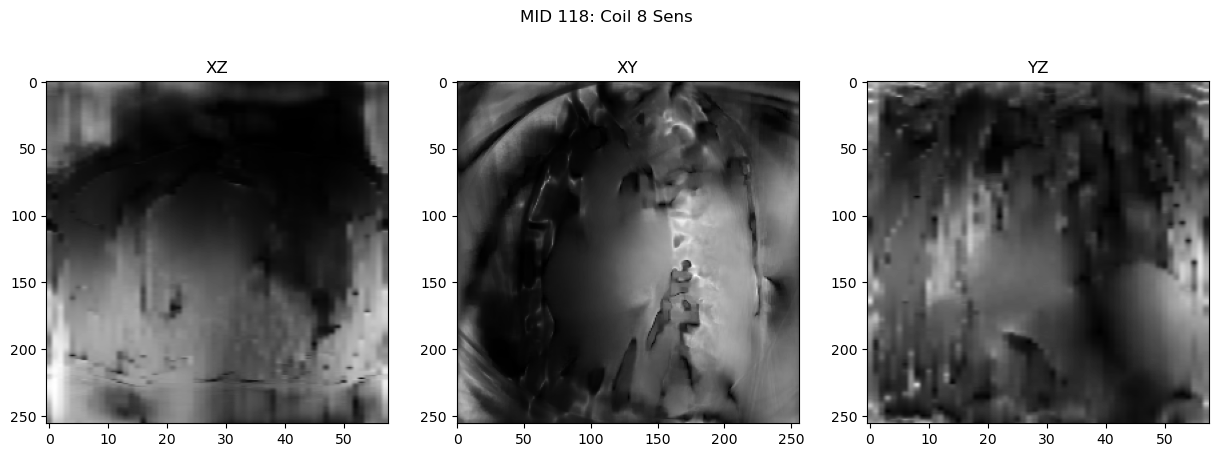

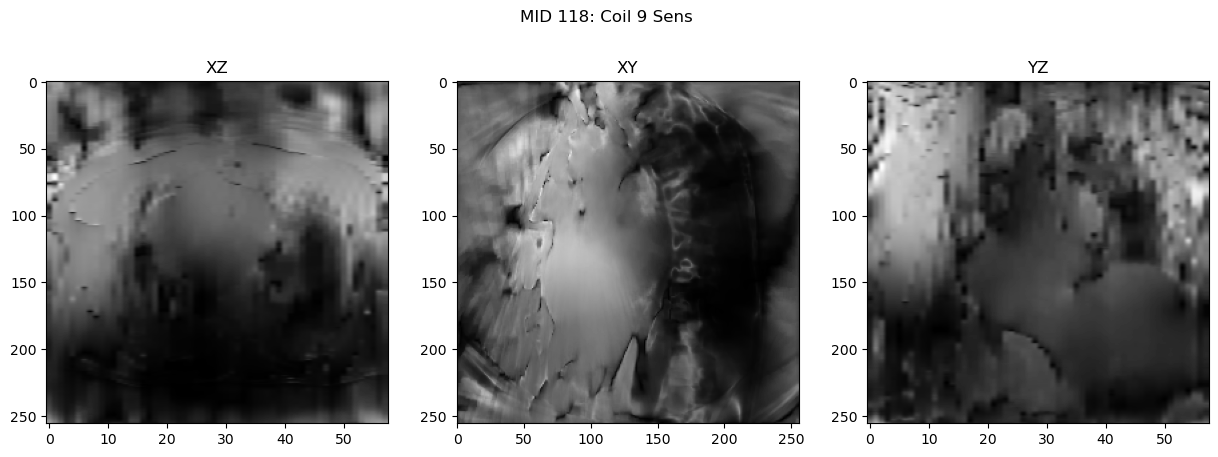

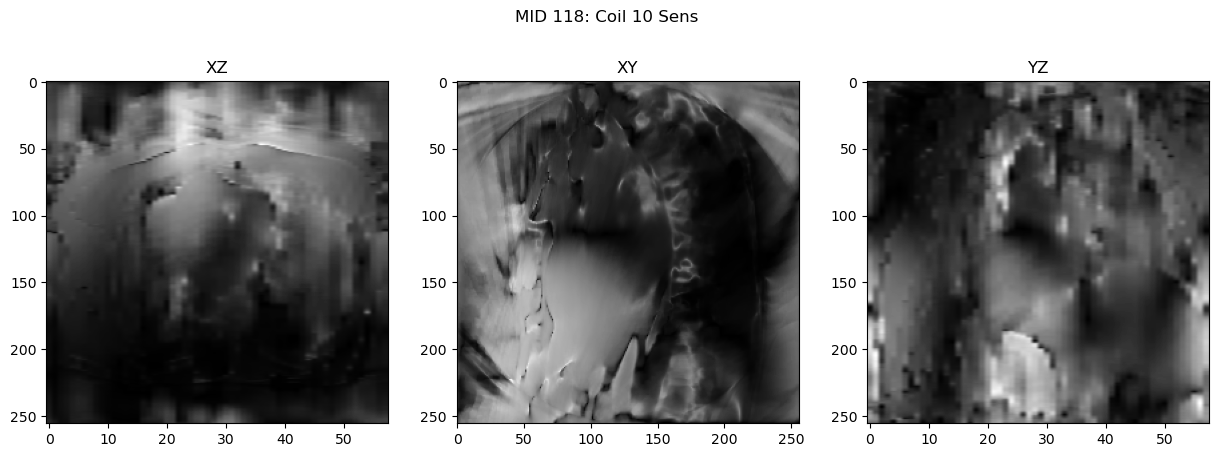

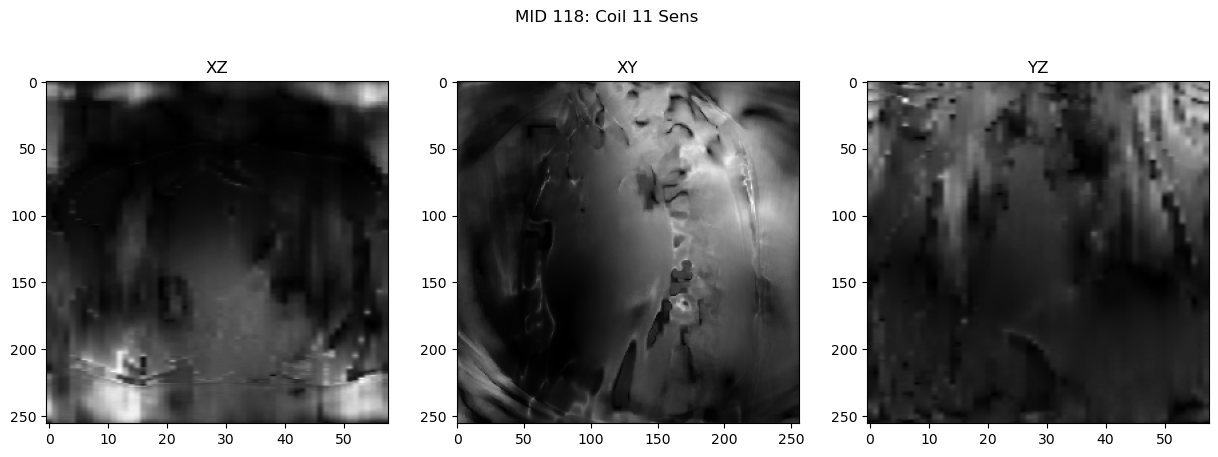

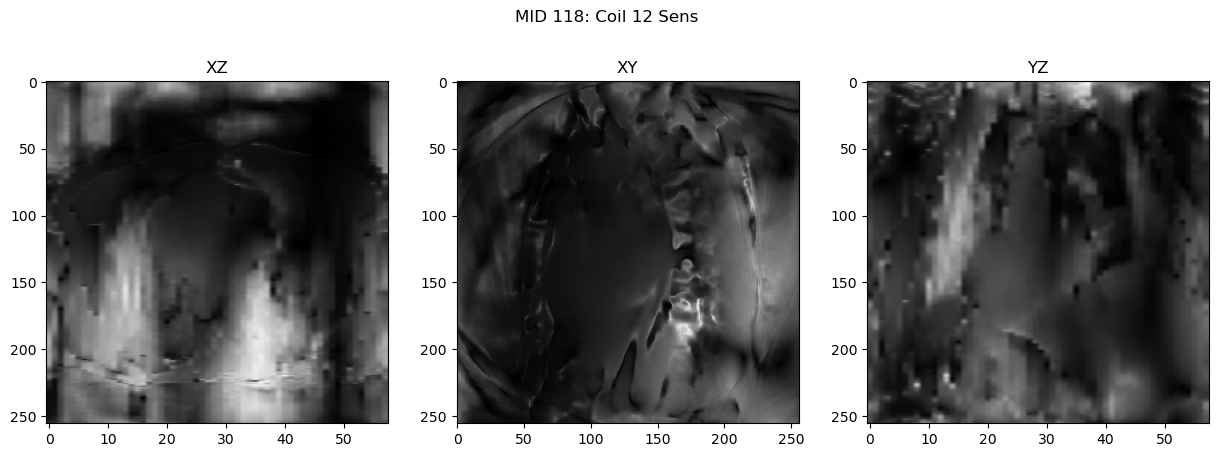

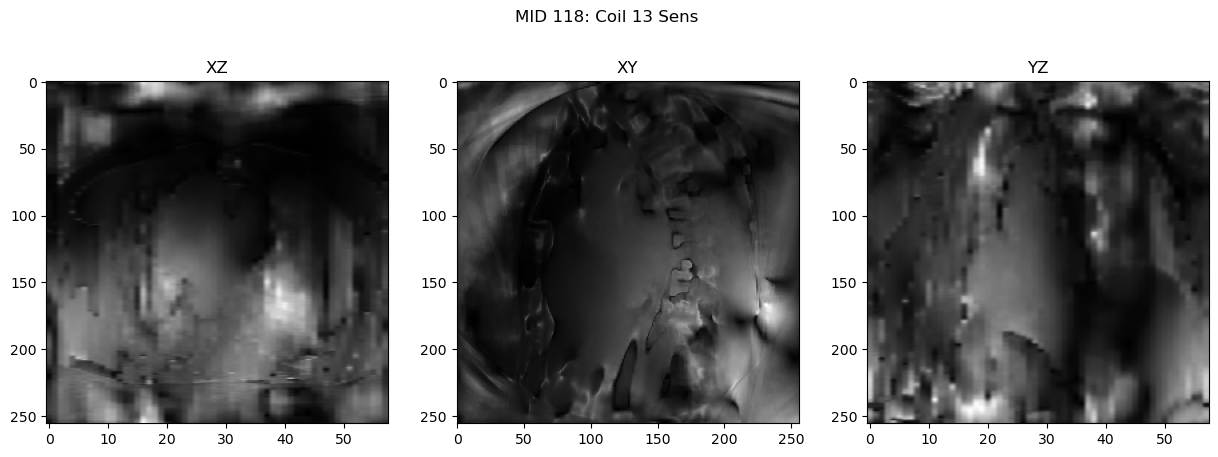

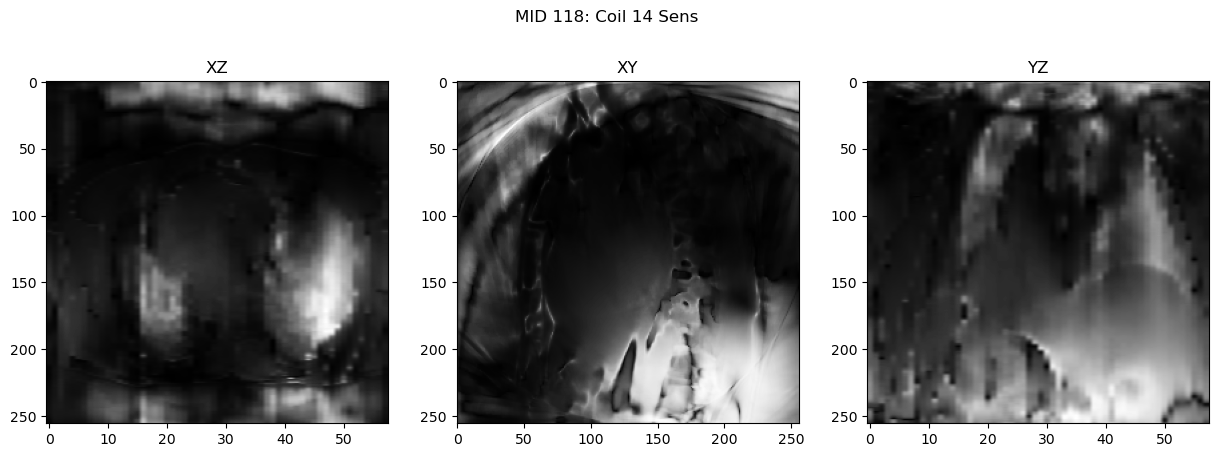

In [23]:
def calculate_coil_sens(recon_all_channels_norm, sos_img, plot=True, coil_idx=None, z_idx=None, y_idx=None, x_idx=None):
    ## Initialize empty array for coil sens images
    ncoils, Nz, Ny, Nx = recon_all_channels_norm.shape
    coil_sens_images = np.zeros((ncoils, Nz, Ny, Nx))

    ## Divide individual coil images by sum of squares
    for i in range(ncoils):
        single_coil_img = recon_all_channels_norm[i] / sos_img
        coil_sens_images[i] = single_coil_img
    
    if plot is True:
        ## Set indices if not set
        if z_idx is None:
            z_idx = Nz//2
        if y_idx is None:
            y_idx = Ny //2
        if x_idx is None:
            x_idx = Nx//2

        if coil_idx is None:
            for i in range(ncoils):
                fig, axs = plt.subplots(1,3, figsize=(15, 5))
                aspect = Nz /Nx

                axs[0].imshow(np.flipud(coil_sens_images[i, :, y_idx, :].T), cmap='gray', aspect=aspect)
                axs[0].set_title("XZ")
                axs[1].imshow(rotate_90(coil_sens_images[i, z_idx, :, :].T), cmap='gray', aspect=1.)
                axs[1].set_title("XY")
                axs[2].imshow(coil_sens_images[i, :, :, x_idx].T, cmap='gray', aspect=aspect)
                axs[2].set_title("YZ")    
                fig.suptitle(f"MID 118: Coil {i} Sens ")
                plt.show()
    
        if coil_idx is not None:
            fig, axs = plt.subplots(1,3, figsize=(15, 5))
            aspect = Nz /Nx

            axs[0].imshow(np.flipud(coil_sens_images[coil_idx, :, y_idx, :].T), cmap='gray', aspect=aspect)
            axs[0].set_title("XZ")
            axs[1].imshow(rotate_90(coil_sens_images[coil_idx, z_idx, :, :].T), cmap='gray', aspect=1.)
            axs[1].set_title("XY")
            axs[2].imshow(coil_sens_images[coil_idx, :, :, x_idx].T, cmap='gray', aspect=aspect)
            axs[2].set_title("YZ")
            fig.suptitle(f"MID 118: Coil {coil_idx} Sens ")
            plt.show()


calculate_coil_sens(recon_all_channels_norm, sos_img)